# Coin segmentation tutorial [1] 

In [3]:
import skimage
skimage.__version__

'0.17.2'

matplotlib inline ensures that plots appear inside of the Jupyter notebook

In [4]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from skimage import data
coins=data.coins()

Goal is to isolate coins from darker background

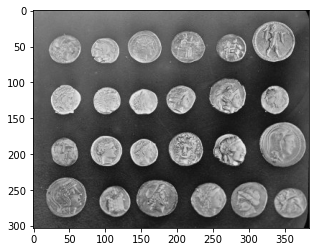

In [6]:
plt.imshow(coins, cmap='gray')

Median filter denoises the image

Original image has lots of details. After applying structural element selem of size 5x5 and median filter image becomes smoother.

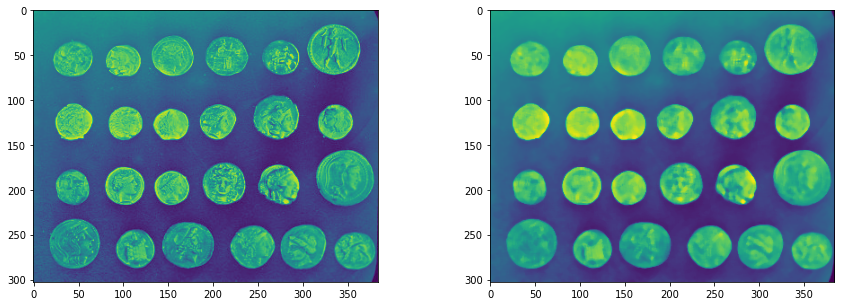

In [10]:
from skimage import filters

coins_denoised = filters.median(coins, selem=np.ones((5, 5)))
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.imshow(coins)
ax1.imshow(coins_denoised)

Edge filter the image using Canny algorithm [2], [3], sigma is standard deviation

Steps of the algorithm: [4]
1. Smooth the image using a Gaussian with sigma width
2. Apply horizontal and vertical Sobel operators to get the gradients within the image. The edge strengh is the norm of the gradient.
3. Thin potential edges to one pixel wide curves. First, find the normal to the edge at each point. This is done by looking at the signs and the relative magnitude of the X-Sobel and Y-Sobel to sort the points into 4 categories: horizontal, vertical, diagonal and antidiagonal. Then look in the normal and reverse directions to see if the values in these directions are greater than the point in question. Use interpolation to get a mix of points instead of picking the one that is closes to the normal.
4. Perform a hysteresis thresholding: first, label all points above the threshold as edges. Then recursively label every point above the low threshold that is 8-connected to a labeled point as an edge.


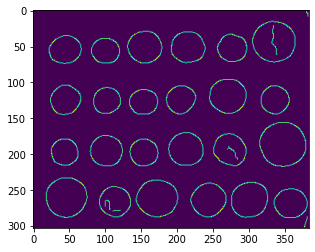

In [11]:
from skimage import feature

edges = feature.canny(coins, sigma=3)

plt.imshow(edges)

Perform exact Euclidian distance transform. Gives values of the Euclidian distance [5]:

$ y_i = \sqrt{\sum_j^n
{(x[j]-b[j])^2}} $

where b[j] is the background point (value 0) with the smallest Euclidian distance to input points x[j] and n is the number of dimensions

When applied to edges obtained via Canny algorithm output is same as original edges, because any background pixel is distance 0 away from backgroung itself and any edge pixel is distance 1 away from the background.

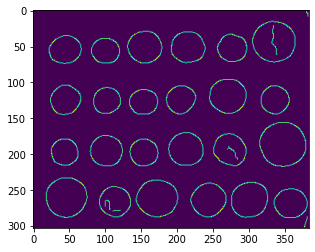

In [21]:
from scipy.ndimage import distance_transform_edt

dt = distance_transform_edt(edges)
plt.imshow(dt)

When applied to inversed edges exact Euclidian transformation tells us how far each pixel is from the coin edge. Farest points (green) are in the middle of a coin as well as outside. Black pixels are those which are close to the edge of a coin.

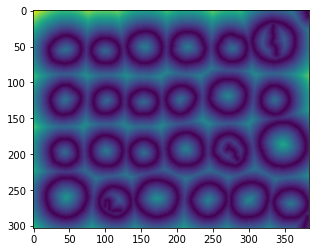

In [24]:
from scipy.ndimage import distance_transform_edt

dt = distance_transform_edt(~edges)
plt.imshow(dt)

Find peaks in the image as coordinate list [6]. Peaks are the local maxima in a region of 2*min_distance+1.

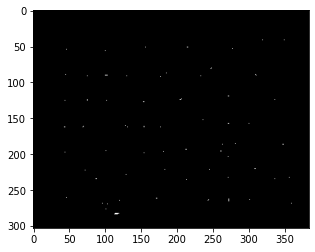

In [39]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray')

In [40]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)
print(peak_idx[:5])

[[186 348]
 [186 347]
 [260  46]
 [261 171]
 [261 172]]


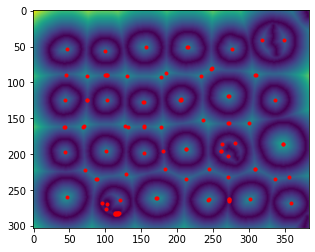

In [33]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

Label features: give each feature a unique number. These numbers will be used by watershed algorithm to label each fountain.

In [43]:
from skimage import measure

markers = measure.label(local_max)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


Negative dt is used in order for edges of coins to become peaks to fill areas inside coins with water coming from the center of each coin.

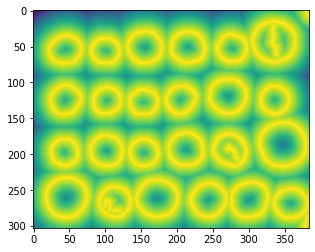

In [57]:
from skimage import morphology, segmentation

plt.imshow(-dt)

Use watershed algorithm. Watershed algorithm treats image it operates upon as topograhic map with brightness of each point representing its height.

mark_boundaries returns image with boundaries between regions highlighted [7]

/home/linuxfan/cvut/bpr/image-segmentation/venv/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


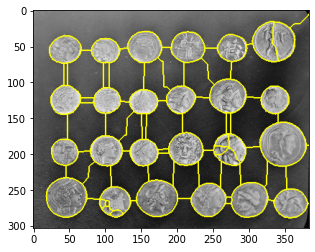

In [58]:
labels = morphology.watershed(-dt, markers)
plt.imshow(segmentation.mark_boundaries(coins, labels))

Returns the rgb image with colors assigned to each region found by watershed [8].

<ipython-input-59-0fc84d8d3525>:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(labels, image=coins))


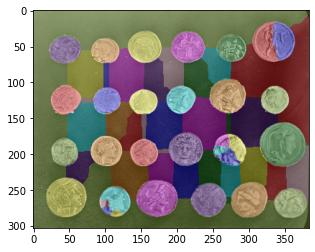

In [59]:
from skimage import color

plt.imshow(color.label2rgb(labels, image=coins))

After applying watershed some coins were split in half as well as backgound was divided to multiple regions. kind='avg' will make label2rgb instead of using uniquel colors for each region use average value of pixels in this region.

<ipython-input-61-0bc8a0ceb671>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(labels, image=coins, kind='avg'), cmap='gray')


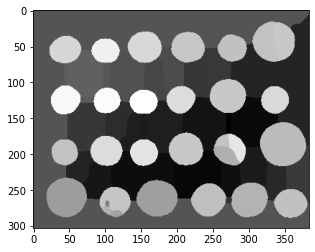

In [61]:
plt.imshow(color.label2rgb(labels, image=coins, kind='avg'), cmap='gray')

Measure properties of label image regions.

In [65]:
regions = measure.regionprops(labels, intensity_image=coins)

(array([ 4.,  5.,  7.,  2.,  5.,  1.,  4.,  3.,  0.,  1.,  0.,  0.,  3.,
         3.,  3., 11.,  2.,  5.,  1.,  3.]),
 array([ 28.93678161,  37.2460494 ,  45.55531719,  53.86458498,
         62.17385277,  70.48312056,  78.79238835,  87.10165614,
         95.41092393, 103.72019172, 112.02945951, 120.3387273 ,
        128.64799509, 136.95726288, 145.26653067, 153.57579846,
        161.88506625, 170.19433404, 178.50360183, 186.81286961,
        195.1221374 ]),
 <BarContainer object of 20 artists>)

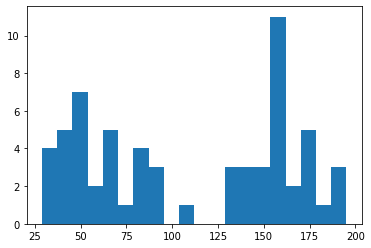

In [66]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20)

As we see on histogram, mean intensities of background regions are clearly separated from mean intensities of coin regions, so coins may be separated from backgroung with the threshold around 125.

Perform KMeans clustering to separate coins from background

In [69]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
region_means = np.array(region_means).reshape(-1,1)
model.fit(region_means)
print(model.cluster_centers_)

[[159.01085159]
 [ 57.47824099]]


In [71]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [73]:
classified_labels = labels.copy()

for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

<ipython-input-74-42f6a46ea7f0>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(classified_labels, image=coins))


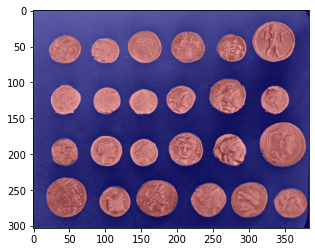

In [74]:
plt.imshow(color.label2rgb(classified_labels, image=coins))

## References

1. https://www.youtube.com/watch?v=STnoJ3YCWus
2. https://doi.org/10.1109/TPAMI.1986.4767851
3. https://en.wikipedia.org/wiki/Canny_edge_detector
4. https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny
5. https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html
6. https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max
7. https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries
8. https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.label2rgb